In [8]:
from res_specialization import *
from matplotlib import pyplot as plt
import sys
import random
import pickle
import warnings

warnings.filterwarnings("ignore", category=FutureWarning) 
plt.rcParams['figure.figsize'] = [10, 5]

In [9]:
TRIALS      = 1000
NUM_TO_SPEC = 3
TOL = 5

diff_eq_params = {"x0": [-20, 10, -.5], 
                  "begin": 0, 
                  "end": 60, 
                  "timesteps":60000}

res_params = {"res_sz": 100, 
              "activ_f": np.tanh,
              "connect_p": .01, 
              "ridge_alpha": .00001, 
              "spect_rad": .9, 
              "gamma": 1., 
              "sigma": .12,
              "uniform_weights": True,
              #"solver": "least squares"
             }

results = dict()


def save_results():
    pickle.dump(results, open("spec_tw.pkl","wb"))
# end

### Model trajectory

In [10]:
t, train_t, u = lorenz_equ(**diff_eq_params )
train_t = t[30000:50000]
test_t  = t[50000:]
data = [train_t,test_t,u]

In [11]:
def plot_pred(data, train_pre, test_pre, fit_err=None):

    train_t, test_t, u = data 
    L2err = L2error(u(train_t), train_pre)
    pre_dist = how_long_accurate(test_pre,u(test_t),tol=5)

    # Plot fit to training curve
    plt.subplot(211)
    res_lines = plt.plot(train_pre.T,c='b',alpha=.5,label="Res Comp")
    act_lines = plt.plot(u(train_t).T,c='g',alpha=.5, label="Actual")
    plt.legend([res_lines[0],act_lines[0]],['Res Comp','Actual'])
    plt.title("Model Fit to Train Data")
    plt.xticks([])
    
    # Plot test predicitons
    plt.subplot(212)
    res_lines = plt.plot(test_pre.T,c='b',alpha=.5,label="Res Comp")
    act_lines = plt.plot(u(test_t).T,c='g',alpha=.5, label="Actual")
    
    # Plot prediction cutoff
    x,y = pre_dist*np.ones(100),np.linspace(-30,50,100)
    cutoff = plt.plot(x,y,c='r')
    plt.title("Model Fit to Test Data")
    plt.legend([res_lines[0],act_lines[0]],['Res Comp','Actual'])

    plt.show()
    
    if fit_err is not None:
        print("Error in fit: {}".format(fit_err))
        
    print("Average L2 Error: {}".format(L2err))
    print("Accurate prediction for {} timesteps".format(pre_dist))
    
def fit_lorenz(data, res_params):
    train_t, test_t, u = data 
    rc = ResComp(3,3, **res_params)

    r_0 = rc.state_0
    err = rc.fit(train_t,u)
    test_pre = rc.predict(test_t)
    train_pre = rc.predict(train_t, r_0=r_0)

    plot_pred(data, train_pre, test_pre, fit_err=err)
    return rc, train_pre, test_pre


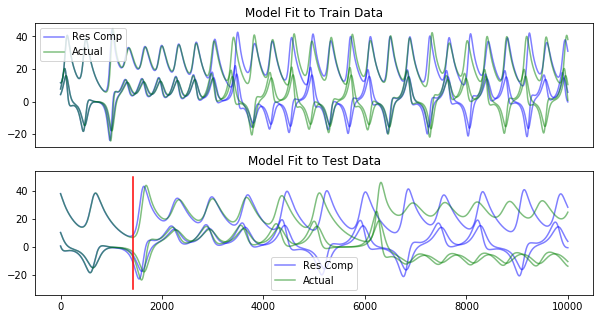

Error in fit: 0.021119149123376157
Average L2 Error: 9.457314834506594
Accurate prediction for 1432 timesteps


In [12]:
res_params = {"res_sz": 100, 
              "activ_f": np.tanh,
              "connect_p": .01, 
              "ridge_alpha": .00001, 
              "spect_rad": .9, 
              "gamma": 1., 
              "sigma": 0.12,
              "uniform_weights": True,
              "solver" : "least squares"
             }

rc, train_pre, test_pre = fit_lorenz(data,res_params)

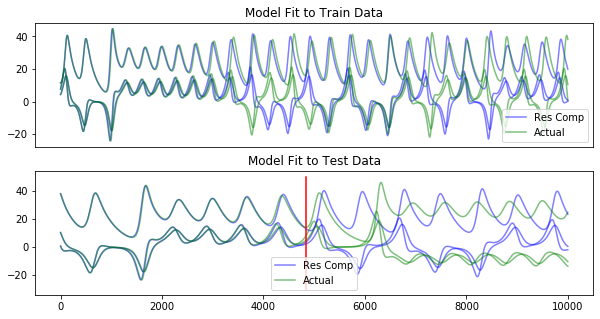

Error in fit: 0.03275079013181634
Average L2 Error: 10.553999730419337
Accurate prediction for 4831 timesteps
Size: 93


In [23]:
NUM_TO_SPEC = 1
A = specialize_best_nodes(rc, NUM_TO_SPEC, u, train_t, u_0=diff_eq_params["x0"])

rc = make_res_comp(A, res_params)
r_0 = rc.state_0
err = rc.fit(train_t,u)
test_pre = rc.predict(test_t)
train_pre = rc.predict(train_t, r_0=r_0)
plot_pred(data, train_pre, test_pre, fit_err=err)
print("Size: {}".format(rc.res.shape[0]))